# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [168]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


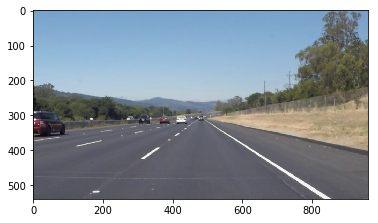

In [169]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [211]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_slopes = []
    right_slopes = []
    left_centers = []
    right_centers = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            center = [(x2 + x1) / 2, (y2 + y1) / 2]

            # Left lane
            if slope < 0:
                left_slopes.append(slope)
                left_centers.append(center)
                                
            # Right lane
            else:
                right_slopes.append(slope)
                right_centers.append(center)

    top_y = 325
    bottom_y = 540
    process_line(img, color, right_slopes, right_centers, top_y, bottom_y)
    process_line(img, color, left_slopes, left_centers, top_y, bottom_y)

    
def process_line(img, color, slopes, centers, top_y, bottom_y):
    """
    Curate, calculate and show a new line from the set of lines defined by slopes and centers
    """
    curated_idx = curate_data_idx(slopes)
    curated_slopes = np.array(slopes)[curated_idx]
    curated_centers = np.array(centers)[curated_idx]
    slope = np.mean(curated_slopes, axis=0)
    center = np.mean(curated_centers, axis=0)
    
    if not np.isnan(slope) and not np.isnan(center).any():
        top_point = calculate_new_point(top_y, slope, center)
        bottom_point = calculate_new_point(bottom_y, slope, center)

        cv2.line(img, top_point, bottom_point, color, 20)
        
def curate_data_idx(arr):
    """
    Return the indexes of the elements that are not outliers
    """
    elements = np.array(arr)

    mean = np.mean(elements, axis=0)
    sd = np.std(elements, axis=0)
    cond = np.logical_and(arr > mean - 0.5 * sd, arr < mean + 0.5 * sd)
    return np.where(cond)
    

def calculate_new_point(y_coordinate, slope, point):
    return (int(point[0] + (y_coordinate - point[1]) / slope), y_coordinate)

    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [167]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

Processing image solidWhiteCurve.jpg
325, 0.5992875691889147, [ 616.5         387.71428571]
540, 0.5992875691889147, [ 616.5         387.71428571]
325, -0.7157114072632597, [ 392.55555556  370.83333333]
540, -0.7157114072632597, [ 392.55555556  370.83333333]
Processing image solidWhiteRight.jpg
325, 0.6318489528242015, [ 696.5   445.25]
540, 0.6318489528242015, [ 696.5   445.25]
325, -0.6954348052840835, [ 361.1  384.2]
540, -0.6954348052840835, [ 361.1  384.2]
Processing image solidYellowCurve.jpg
325, 0.5981188583147847, [ 659.625  415.625]
540, 0.5981188583147847, [ 659.625  415.625]
325, -0.7383186705767351, [ 237.25  484.75]
540, -0.7383186705767351, [ 237.25  484.75]
Processing image solidYellowCurve2.jpg
325, 0.605314960497052, [ 554.58333333  352.58333333]
540, 0.605314960497052, [ 554.58333333  352.58333333]
325, -0.7166521382839596, [ 312.57142857  418.64285714]
540, -0.7166521382839596, [ 312.57142857  418.64285714]
Processing image solidYellowLeft.jpg
325, 0.620401337792642

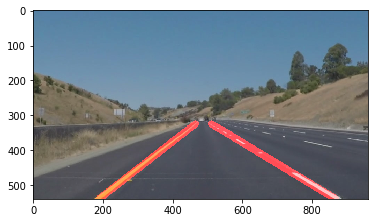

In [212]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

# Pipeline for a single image
def pipeline(img):
    """
    Chain of operations to process an image to find lane lines
    """
    # 1. Convert the image to grayscale
    gray_img = grayscale(img)
    
    result = gray_img
    
    # 2. Region masking
    img_shape = img.shape
    
    # Let's first try with a triangle as it seems to fit with the images provided.
    # We can later see if a isosceles trapezium fits better
    
    # TODO Vertices related to img_shape values
    vertices = np.array([[475, 300], [130, 540], [875, 540]], dtype=np.int32)
    # Note: fillPoly requires a list of points as an input
    result = region_of_interest(gray_img, [vertices])
    
    # 3. Suppress noise and spurious gradient by applying Gaussian smoothing
    gaussian_kernel_size = 5
    result = gaussian_blur(result, gaussian_kernel_size)
    
    # 4. Apply Canny Edge Detector
    canny_low_threshold = 50
    canny_high_threshold = 150
    result = canny(result, canny_low_threshold, canny_high_threshold)
    
    # 5. Apply Hough Transform
    rho = 2
    theta = np.pi/180 # angular resolution in radians of the Hough grid. 1 degree
    threshold = 15 # 15 points in image space need to be associated with each line segment
    min_line_length = 40 # In pixels
    max_line_gap = 20 # In pixels
    result = hough_lines(result, rho, theta, threshold, min_line_length, max_line_gap)
    
    return result

images_dir = "test_images"
images_output_dir = 'test_images_output'
images = os.listdir(images_dir)
for image_file in images:
    print('{} {}'.format('Processing image', image_file))
    image = mpimg.imread(os.path.join(images_dir, image_file))
    result = pipeline(image)
    cv2.imwrite(os.path.join(images_output_dir, image_file), result)
    result = weighted_img(result, image)
    plt.imshow(result)
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [184]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [185]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = pipeline(image)
    result = weighted_img(result, image)
    return result

Let's try the one with the solid white lane on the right first ...

In [213]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

325, 0.6033356966880041, [ 617.625  390.375]
540, 0.6033356966880041, [ 617.625  390.375]
325, -0.717670011148272, [ 433.   339.5]
540, -0.717670011148272, [ 433.   339.5]
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4






  0%|          | 0/222 [00:00<?, ?it/s]



  2%|▏         | 4/222 [00:00<00:07, 29.52it/s]

325, 0.6033356966880041, [ 617.625  390.375]
540, 0.6033356966880041, [ 617.625  390.375]
325, -0.717670011148272, [ 433.   339.5]
540, -0.717670011148272, [ 433.   339.5]
325, 0.6190476190476191, [ 722.  459.]
540, 0.6190476190476191, [ 722.  459.]
325, -0.7435923366260083, [ 389.91666667  370.58333333]
540, -0.7435923366260083, [ 389.91666667  370.58333333]
325, 0.6375, [ 560.   356.5]
540, 0.6375, [ 560.   356.5]
325, -0.7161579161579161, [ 325.33333333  406.83333333]
540, -0.7161579161579161, [ 325.33333333  406.83333333]
325, 0.6030764290304852, [ 581.08333333  367.83333333]
540, 0.6030764290304852, [ 581.08333333  367.83333333]
325, -0.7235103170094691, [ 298.25        430.16666667]
540, -0.7235103170094691, [ 298.25        430.16666667]
325, 0.6194106788887516, [ 706.    442.25]
540, 0.6194106788887516, [ 706.    442.25]
325, -0.6881313131313131, [ 317.  409.]
540, -0.6881313131313131, [ 317.  409.]


325, 0.6125740618828177, [ 788.25  500.5 ]
540, 0.6125740618828177, [ 788.25  500.5 ]
325, -0.7142255892255892, [ 354.          391.16666667]
540, -0.7142255892255892, [ 354.          391.16666667]






  3%|▎         | 7/222 [00:00<00:07, 27.33it/s]



  5%|▍         | 10/222 [00:00<00:08, 25.83it/s]

325, 0.5970575872215217, [ 599.33333333  376.        ]
540, 0.5970575872215217, [ 599.33333333  376.        ]
325, -0.6923076923076923, [ 435.  334.]
540, -0.6923076923076923, [ 435.  334.]
325, 0.589404006518611, [ 705.    439.25]
540, 0.589404006518611, [ 705.    439.25]
325, -0.7215425705165788, [ 382.83333333  370.66666667]
540, -0.7215425705165788, [ 382.83333333  370.66666667]
325, 0.6132960971245295, [ 676.1875  425.5   ]
540, 0.6132960971245295, [ 676.1875  425.5   ]
325, -0.7218553505318211, [ 368.875  380.875]
540, -0.7218553505318211, [ 368.875  380.875]
325, 0.6447535482230224, [ 577.625  367.   ]
540, 0.6447535482230224, [ 577.625  367.   ]
325, -0.7048259231207858, [ 294.3  428.9]
540, -0.7048259231207858, [ 294.3  428.9]
325, 0.6112940969804195, [ 601.66666667  383.33333333]





  5%|▌         | 12/222 [00:00<00:09, 23.07it/s]



  7%|▋         | 15/222 [00:00<00:08, 23.94it/s]


540, 0.6112940969804195, [ 601.66666667  383.33333333]
325, -0.7232213935098886, [ 355.83333333  392.94444444]
540, -0.7232213935098886, [ 355.83333333  392.94444444]
325, 0.6076094895290334, [ 711.1  444.6]
540, 0.6076094895290334, [ 711.1  444.6]
325, -0.7386904761904762, [ 359.75  392.  ]
540, -0.7386904761904762, [ 359.75  392.  ]
325, 0.6129285192435987, [ 685.9  433.6]
540, 0.6129285192435987, [ 685.9  433.6]
325, -0.7123117623117623, [ 377.66666667  375.33333333]
540, -0.7123117623117623, [ 377.66666667  375.33333333]
325, 0.614809342848315, [ 659.83333333  413.22222222]
540, 0.614809342848315, [ 659.83333333  413.22222222]
325, -0.700350796919088, [ 343.16666667  393.66666667]
540, -0.700350796919088, [ 343.16666667  393.66666667]
325, 0.6334333219053649, [ 692.5         436.88888889]
540, 0.6334333219053649, [ 692.5         436.88888889]
325, -0.6992385873142452, [ 344.91666667  396.        ]
540, -0.6992385873142452, [ 344.91666667  396.        ]
325, 0.6260685335298453, [ 6





  8%|▊         | 18/222 [00:00<00:08, 24.51it/s]



  9%|▉         | 21/222 [00:00<00:07, 25.41it/s]

325, 0.6308293669387655, [ 670.16666667  418.33333333]
540, 0.6308293669387655, [ 670.16666667  418.33333333]
325, -0.7190590541110586, [ 387.1  364.1]
540, -0.7190590541110586, [ 387.1  364.1]
325, 0.6207469506053209, [ 711.   443.7]
540, 0.6207469506053209, [ 711.   443.7]
325, -0.7028129066789808, [ 362.625  379.25 ]
540, -0.7028129066789808, [ 362.625  379.25 ]
325, 0.62008702511911, [ 762.375  473.5  ]
540, 0.62008702511911, [ 762.375  473.5  ]
325, -0.7036247054737819, [ 376.9  374. ]
540, -0.7036247054737819, [ 376.9  374. ]
325, 0.6088073328881279, [ 708.22222222  442.22222222]
540, 0.6088073328881279, [ 708.22222222  442.22222222]
325, -0.6993509801971493, [ 379.42307692  374.88461538]
540, -0.6993509801971493, [ 379.42307692  374.88461538]
325, 0.626993735764523, [ 627.125  399.75 ]
540, 0.626993735764523, [ 627.125  399.75 ]
325, -0.7085398678732209, [ 303.5    426.625]
540, -0.7085398678732209, [ 303.5    426.625]
325, 0.6271599074803237, [ 653.15  414.7 ]
540, 0.6271599074





 12%|█▏        | 26/222 [00:00<00:06, 29.12it/s]



 14%|█▎        | 30/222 [00:01<00:06, 31.60it/s]

325, 0.6281316817611916, [ 643.83333333  407.83333333]
540, 0.6281316817611916, [ 643.83333333  407.83333333]
325, -0.7073416381326171, [ 331.5         401.66666667]
540, -0.7073416381326171, [ 331.5         401.66666667]
325, 0.62948513577761, [ 707.          449.33333333]
540, 0.62948513577761, [ 707.          449.33333333]
325, -0.7080393337856337, [ 350.58333333  395.16666667]
540, -0.7080393337856337, [ 350.58333333  395.16666667]
325, 0.6365356872716236, [ 668.41666667  427.33333333]
540, 0.6365356872716236, [ 668.41666667  427.33333333]
325, -0.7297619047619048, [ 263.  454.]
540, -0.7297619047619048, [ 263.  454.]
325, 0.6246147131250873, [ 696.875  437.5  ]
540, 0.6246147131250873, [ 696.875  437.5  ]
325, -0.7114877589453861, [ 329.  401.]
540, -0.7114877589453861, [ 329.  401.]
325, 0.6205613313422279, [ 675.33333333  424.75      ]
540, 0.6205613313422279, [ 675.33333333  424.75      ]
325, -0.7178691735213474, [ 414.5  349. ]
540, -0.7178691735213474, [ 414.5  349. ]
325, 0





 16%|█▌        | 35/222 [00:01<00:05, 33.74it/s]



 18%|█▊        | 40/222 [00:01<00:04, 36.57it/s]

325, 0.6153206737240351, [ 714.4  446.3]
540, 0.6153206737240351, [ 714.4  446.3]
325, -0.7206790123456791, [ 449.66666667  326.        ]
540, -0.7206790123456791, [ 449.66666667  326.        ]
325, 0.6271667456911245, [ 686.125  432.625]
540, 0.6271667456911245, [ 686.125  432.625]
325, -0.6892228990887612, [ 339.44444444  402.72222222]
540, -0.6892228990887612, [ 339.44444444  402.72222222]
325, 0.6185570003713199, [ 703.04166667  441.08333333]
540, 0.6185570003713199, [ 703.04166667  441.08333333]
325, -0.7165648564149685, [ 315.5    420.375]
540, -0.7165648564149685, [ 315.5    420.375]
325, 0.6050644236211427, [ 678.77272727  425.31818182]
540, 0.6050644236211427, [ 678.77272727  425.31818182]
325, -0.7188832227262311, [ 308.125  426.   ]
540, -0.7188832227262311, [ 308.125  426.   ]
325, 0.6302131472097682, [ 648.91666667  415.08333333]
540, 0.6302131472097682, [ 648.91666667  415.08333333]
325, -0.7153829668681153, [ 345.66666667  396.66666667]
540, -0.7153829668681153, [ 345.66





 20%|█▉        | 44/222 [00:01<00:04, 36.40it/s]

325, 0.625, [ 727.  458.]
540, 0.625, [ 727.  458.]
325, -0.7012517034029941, [ 379.33333333  370.83333333]
540, -0.7012517034029941, [ 379.33333333  370.83333333]
325, 0.6442263425935382, [ 658.75  419.5 ]
540, 0.6442263425935382, [ 658.75  419.5 ]
325, -0.6853860408961132, [ 349.1875  391.1875]
540, -0.6853860408961132, [ 349.1875  391.1875]
325, 0.6253767768746652, [ 749.1875  470.75  ]
540, 0.6253767768746652, [ 749.1875  470.75  ]
325, -0.6992082175871432, [ 347.5   389.75]
540, -0.6992082175871432, [ 347.5   389.75]
325, 0.6074453089033844, [ 694.    434.75]
540, 0.6074453089033844, [ 694.    434.75]
325, -0.7168850760946278, [ 340.9  396.9]
540, -0.7168850760946278, [ 340.9  396.9]






 22%|██▏       | 48/222 [00:01<00:06, 28.17it/s]



 23%|██▎       | 52/222 [00:01<00:06, 26.90it/s]

325, 0.5956495282909738, [ 692.1   433.15]
540, 0.5956495282909738, [ 692.1   433.15]
325, -0.7136037893958542, [ 334.21428571  403.92857143]
540, -0.7136037893958542, [ 334.21428571  403.92857143]
325, 0.6071736544398793, [ 652.71428571  410.57142857]
540, 0.6071736544398793, [ 652.71428571  410.57142857]
325, -0.7116521434425811, [ 346.61111111  395.44444444]
540, -0.7116521434425811, [ 346.61111111  395.44444444]
325, 0.618065628680161, [ 686.64285714  432.71428571]
540, 0.618065628680161, [ 686.64285714  432.71428571]
325, -0.7184873949579832, [ 426.5         338.16666667]
540, -0.7184873949579832, [ 426.5         338.16666667]
325, 0.6273240155402273, [ 667.14285714  420.71428571]
540, 0.6273240155402273, [ 667.14285714  420.71428571]
325, -0.7196762720156443, [ 363.    383.75]
540, -0.7196762720156443, [ 363.    383.75]
325, 0.6106913951242186, [ 663.88888889  417.16666667]
540, 0.6106913951242186, [ 663.88888889  417.16666667]
325, -0.701096627137298, [ 214.4  482.1]
540, -0.701





 25%|██▍       | 55/222 [00:01<00:06, 24.64it/s]

325, 0.6260905687783159, [ 676.66666667  427.16666667]
540, 0.6260905687783159, [ 676.66666667  427.16666667]
325, -0.7099401511896918, [ 349.11111111  389.05555556]
540, -0.7099401511896918, [ 349.11111111  389.05555556]
325, 0.6290445203272985, [ 621.5  396.4]
540, 0.6290445203272985, [ 621.5  396.4]
325, -0.6895318624543401, [ 336.8  399.8]
540, -0.6895318624543401, [ 336.8  399.8]
325, 0.6149828861768231, [ 641.0625  402.1875]
540, 0.6149828861768231, [ 641.0625  402.1875]
325, -0.6696397622543023, [ 267.5         445.66666667]
540, -0.6696397622543023, [ 267.5         445.66666667]
325, 0.6319348447818098, [ 679.8  433.5]
540, 0.6319348447818098, [ 679.8  433.5]
325, -0.6984347220530462, [ 372.25   373.875]
540, -0.6984347220530462, [ 372.25   373.875]






 26%|██▌       | 58/222 [00:02<00:07, 22.46it/s]



 27%|██▋       | 61/222 [00:02<00:06, 23.06it/s]

325, 0.6259151251509611, [ 648.59090909  412.72727273]
540, 0.6259151251509611, [ 648.59090909  412.72727273]
325, -0.6988544646806358, [ 367.7  377.5]
540, -0.6988544646806358, [ 367.7  377.5]
325, 0.6255093862420369, [ 657.5     420.3125]
540, 0.6255093862420369, [ 657.5     420.3125]
325, -0.6682389937106918, [ 438.    335.25]
540, -0.6682389937106918, [ 438.    335.25]
325, 0.623406162464986, [ 624.6  395.4]
540, 0.623406162464986, [ 624.6  395.4]
325, -0.6901645873276094, [ 301.25   423.125]
540, -0.6901645873276094, [ 301.25   423.125]
325, 0.6198304168185168, [ 756.41666667  474.5       ]
540, 0.6198304168185168, [ 756.41666667  474.5       ]
325, -0.7058314203962046, [ 382.5  371.5]
540, -0.7058314203962046, [ 382.5  371.5]
325, 0.6360409258473885, [ 629.125  402.125]
540, 0.6360409258473885, [ 629.125  402.125]
325, -0.7037589232472953, [ 298.5   429.25]
540, -0.7037589232472953, [ 298.5   429.25]
325, 0.6352505930369462, [ 706.625       449.95833333]
540, 0.6352505930369462, 





 29%|██▉       | 64/222 [00:02<00:06, 23.35it/s]



 30%|███       | 67/222 [00:02<00:06, 22.34it/s]


325, -0.6676033266310193, [ 329.33333333  406.58333333]
540, -0.6676033266310193, [ 329.33333333  406.58333333]
325, 0.6364947905829949, [ 672.07692308  429.        ]
540, 0.6364947905829949, [ 672.07692308  429.        ]
325, -0.6884021901443504, [ 281.5  443.5]
540, -0.6884021901443504, [ 281.5  443.5]
325, 0.6347416956481866, [ 686.35  439.1 ]
540, 0.6347416956481866, [ 686.35  439.1 ]
325, -0.6986996188610094, [ 376.25  373.  ]
540, -0.6986996188610094, [ 376.25  373.  ]
325, 0.6215667417115043, [ 645.11111111  406.44444444]
540, 0.6215667417115043, [ 645.11111111  406.44444444]
325, -0.7073170731707317, [ 449.5  317.5]
540, -0.7073170731707317, [ 449.5  317.5]
325, 0.6274983510390164, [ 661.          417.08333333]
540, 0.6274983510390164, [ 661.          417.08333333]
325, -0.6809129559185501, [ 289.5  432.5]
540, -0.6809129559185501, [ 289.5  432.5]






 32%|███▏      | 70/222 [00:02<00:06, 22.58it/s]

325, 0.6569207050779545, [ 701.2  450. ]
540, 0.6569207050779545, [ 701.2  450. ]
325, -0.6883741445241338, [ 374.     375.125]
540, -0.6883741445241338, [ 374.     375.125]
325, 0.64935175385368, [ 699.8  448. ]
540, 0.64935175385368, [ 699.8  448. ]
325, -0.6693775373958638, [ 352.5         388.33333333]
540, -0.6693775373958638, [ 352.5         388.33333333]
325, 0.6326614609414907, [ 636.375  401.125]
540, 0.6326614609414907, [ 636.375  401.125]
325, -0.7000078610302408, [ 369.4  376.8]
540, -0.7000078610302408, [ 369.4  376.8]
325, 0.6518018452612752, [ 664.625  425.5  ]
540, 0.6518018452612752, [ 664.625  425.5  ]
325, -0.7149582772459468, [ 371.83333333  376.58333333]
540, -0.7149582772459468, [ 371.83333333  376.58333333]
325, 0.6212504485927143, [ 665.75   416.125]
540, 0.6212504485927143, [ 665.75   416.125]
325, -0.6701339072214251, [ 260.75   450.625]
540, -0.6701339072214251, [ 260.75   450.625]






 33%|███▎      | 73/222 [00:02<00:06, 22.54it/s]



 34%|███▍      | 76/222 [00:02<00:06, 23.57it/s]

325, 0.6425478038693723, [ 681.11111111  432.88888889]
540, 0.6425478038693723, [ 681.11111111  432.88888889]
325, -0.6877105185951657, [ 271.35714286  445.71428571]
540, -0.6877105185951657, [ 271.35714286  445.71428571]
325, 0.620602776153403, [ 684.1  430.1]
540, 0.620602776153403, [ 684.1  430.1]
325, -0.7095550825685513, [ 323.86363636  409.90909091]
540, -0.7095550825685513, [ 323.86363636  409.90909091]
325, 0.6128150942580423, [ 683.          426.91666667]
540, 0.6128150942580423, [ 683.          426.91666667]
325, -0.7040035831380063, [ 328.3125  406.6875]
540, -0.7040035831380063, [ 328.3125  406.6875]
325, 0.6382182420650303, [ 655.5   416.25]
540, 0.6382182420650303, [ 655.5   416.25]
325, -0.7484848484848485, [ 410.16666667  346.83333333]
540, -0.7484848484848485, [ 410.16666667  346.83333333]
325, 0.6262526117789274, [ 688.71428571  433.5       ]
540, 0.6262526117789274, [ 688.71428571  433.5       ]
325, -0.696285272421945, [ 321.41666667  408.16666667]
540, -0.696285272





 36%|███▌      | 79/222 [00:02<00:06, 23.08it/s]



 37%|███▋      | 82/222 [00:03<00:05, 24.20it/s]

325, 0.6422549833887043, [ 641.625  408.375]
540, 0.6422549833887043, [ 641.625  408.375]
325, -0.672299630633821, [ 336.66666667  398.83333333]
540, -0.672299630633821, [ 336.66666667  398.83333333]
325, 0.6384524680537398, [ 643.27777778  413.83333333]
540, 0.6384524680537398, [ 643.27777778  413.83333333]
325, -0.6986286695963443, [ 367.   377.9]
540, -0.6986286695963443, [ 367.   377.9]
325, 0.6530136343502133, [ 702.875  452.   ]
540, 0.6530136343502133, [ 702.875  452.   ]
325, -0.7015236328290534, [ 360.          380.83333333]
540, -0.7015236328290534, [ 360.          380.83333333]
325, 0.65416769723851, [ 660.61111111  420.        ]
540, 0.65416769723851, [ 660.61111111  420.        ]
325, -0.6869265607070485, [ 295.33333333  427.        ]
540, -0.6869265607070485, [ 295.33333333  427.        ]
325, 0.6478462297226302, [ 635.5  407.6]
540, 0.6478462297226302, [ 635.5  407.6]
325, -0.7009792969016875, [ 333.3  398.9]
540, -0.7009792969016875, [ 333.3  398.9]
325, 0.6567812269031





 38%|███▊      | 85/222 [00:03<00:06, 22.71it/s]



 40%|███▉      | 88/222 [00:03<00:05, 23.28it/s]

325, 0.6193434343434343, [ 672.8  419.9]
540, 0.6193434343434343, [ 672.8  419.9]
325, -0.7024679719253575, [ 358.64285714  382.35714286]
540, -0.7024679719253575, [ 358.64285714  382.35714286]
325, 0.6411912365401173, [ 682.83333333  432.25      ]
540, 0.6411912365401173, [ 682.83333333  432.25      ]
325, -0.681641019786234, [ 348.66666667  391.33333333]
540, -0.681641019786234, [ 348.66666667  391.33333333]
325, 0.6388888888888888, [ 552.75  352.25]
540, 0.6388888888888888, [ 552.75  352.25]
325, -0.6641799381685067, [ 292.5  429. ]
540, -0.6641799381685067, [ 292.5  429. ]
325, 0.647927302582475, [ 676.625  435.75 ]
540, 0.647927302582475, [ 676.625  435.75 ]
325, -0.6903167351133244, [ 287.92857143  432.78571429]
540, -0.6903167351133244, [ 287.92857143  432.78571429]
325, 0.6428919532008737, [ 600.5         386.66666667]
540, 0.6428919532008737, [ 600.5         386.66666667]
325, -0.6899870362664651, [ 327.125  406.125]
540, -0.6899870362664651, [ 327.125  406.125]






 41%|████      | 91/222 [00:03<00:05, 23.35it/s]



 42%|████▏     | 94/222 [00:03<00:05, 24.25it/s]

325, 0.6900434514143771, [ 681.16666667  444.08333333]
540, 0.6900434514143771, [ 681.16666667  444.08333333]
325, -0.7010322706928351, [ 344.44444444  393.88888889]
540, -0.7010322706928351, [ 344.44444444  393.88888889]
325, 0.6494759195606653, [ 662.5    427.125]
540, 0.6494759195606653, [ 662.5    427.125]
325, -0.6738475775234186, [ 326.08333333  404.66666667]
540, -0.6738475775234186, [ 326.08333333  404.66666667]
325, 0.6578057762499286, [ 667.75  431.75]
540, 0.6578057762499286, [ 667.75  431.75]
325, -0.693632250440774, [ 346.   391.5]
540, -0.693632250440774, [ 346.   391.5]
325, 0.6610169491525424, [ 800.5  518.5]
540, 0.6610169491525424, [ 800.5  518.5]
325, -0.6737032621466583, [ 382.125  367.125]
540, -0.6737032621466583, [ 382.125  367.125]
325, 0.6324584810528587, [ 653.35  413.65]
540, 0.6324584810528587, [ 653.35  413.65]
325, -0.7047275079742344, [ 337.66666667  398.33333333]
540, -0.7047275079742344, [ 337.66666667  398.33333333]
325, 0.6502477477477477, [ 682.75   





 44%|████▎     | 97/222 [00:03<00:05, 23.66it/s]

325, 0.6654677022324081, [ 656.83333333  422.83333333]
540, 0.6654677022324081, [ 656.83333333  422.83333333]
325, -0.7000166268392668, [ 318.875  412.5  ]
540, -0.7000166268392668, [ 318.875  412.5  ]
325, 0.6832242743205156, [ 642.35714286  413.71428571]
540, 0.6832242743205156, [ 642.35714286  413.71428571]
325, -0.6984270870113847, [ 276.2  440.5]
540, -0.6984270870113847, [ 276.2  440.5]
325, 0.6829710144927535, [ 582.          370.16666667]
540, 0.6829710144927535, [ 582.          370.16666667]
325, -0.6977690353155482, [ 323.08333333  409.25      ]
540, -0.6977690353155482, [ 323.08333333  409.25      ]
325, 0.7042493062652901, [ 627.   400.1]
540, 0.7042493062652901, [ 627.   400.1]
325, -0.70578160694653, [ 314.6  412.1]
540, -0.70578160694653, [ 314.6  412.1]
325, 0.6411472448057813, [ 677.25  420.75]
540, 0.6411472448057813, [ 677.25  420.75]
325, -0.6612021857923497, [ 235.16666667  470.        ]
540, -0.6612021857923497, [ 235.16666667  470.        ]






 45%|████▌     | 100/222 [00:03<00:05, 23.94it/s]



 46%|████▋     | 103/222 [00:04<00:05, 20.84it/s]

325, 0.6558459960594856, [ 695.4  444.9]
540, 0.6558459960594856, [ 695.4  444.9]
325, -0.6965973378305973, [ 305.64285714  421.14285714]
540, -0.6965973378305973, [ 305.64285714  421.14285714]
325, 0.6657096977416217, [ 713.75   458.875]
540, 0.6657096977416217, [ 713.75   458.875]
325, -0.7072251681276528, [ 302.625  421.875]
540, -0.7072251681276528, [ 302.625  421.875]
325, 0.6616795110284348, [ 614.5   390.75]
540, 0.6616795110284348, [ 614.5   390.75]
325, -0.6888888888888889, [ 383.5  374.5]
540, -0.6888888888888889, [ 383.5  374.5]
325, 0.6580032110890861, [ 686.6  441. ]
540, 0.6580032110890861, [ 686.6  441. ]
325, -0.7088461538461539, [ 438.25  335.25]
540, -0.7088461538461539, [ 438.25  335.25]






 48%|████▊     | 106/222 [00:04<00:05, 21.05it/s]

325, 0.6431730237700387, [ 522.    328.75]
540, 0.6431730237700387, [ 522.    328.75]
325, -0.6988795518207283, [ 300.25  421.  ]
540, -0.6988795518207283, [ 300.25  421.  ]
325, 0.6647958288497657, [ 687.8125  437.875 ]
540, 0.6647958288497657, [ 687.8125  437.875 ]
325, -0.6864525918042363, [ 352.8125  392.1875]
540, -0.6864525918042363, [ 352.8125  392.1875]
325, 0.6478035331249719, [ 754.  484.]
540, 0.6478035331249719, [ 754.  484.]
325, -0.6937660356424659, [ 424.33333333  344.66666667]
540, -0.6937660356424659, [ 424.33333333  344.66666667]
325, 0.6403818805700954, [ 632.08333333  402.        ]
540, 0.6403818805700954, [ 632.08333333  402.        ]
325, -0.6820679401804032, [ 354.5   388.75]
540, -0.6820679401804032, [ 354.5   388.75]
325, 0.64473033151905, [ 683.75  435.  ]
540, 0.64473033151905, [ 683.75  435.  ]





 49%|████▉     | 109/222 [00:04<00:05, 20.51it/s]



 50%|█████     | 112/222 [00:04<00:04, 22.06it/s]


325, -0.6698910563121089, [ 345.4  392.1]
540, -0.6698910563121089, [ 345.4  392.1]
325, 0.646966366966367, [ 646.3  411.1]
540, 0.646966366966367, [ 646.3  411.1]
325, -0.6923004067078945, [ 396.66666667  356.83333333]
540, -0.6923004067078945, [ 396.66666667  356.83333333]
325, 0.632064460885593, [ 689.875  438.5  ]
540, 0.632064460885593, [ 689.875  438.5  ]
325, -0.6882226874003189, [ 224.125  477.5  ]
540, -0.6882226874003189, [ 224.125  477.5  ]
325, 0.5974109082044236, [ 667.5  415. ]
540, 0.5974109082044236, [ 667.5  415. ]
325, -0.6950144393522306, [ 281.16666667  438.33333333]
540, -0.6950144393522306, [ 281.16666667  438.33333333]
325, 0.6340095855166831, [ 708.375  442.75 ]
540, 0.6340095855166831, [ 708.375  442.75 ]
325, -0.6904772538728396, [ 334.1  404.5]
540, -0.6904772538728396, [ 334.1  404.5]






 52%|█████▏    | 115/222 [00:04<00:04, 22.02it/s]



 53%|█████▎    | 118/222 [00:04<00:04, 23.92it/s]

325, 0.6506993409024747, [ 717.58333333  451.5       ]
540, 0.6506993409024747, [ 717.58333333  451.5       ]
325, -0.6926978365515553, [ 385.92857143  369.        ]
540, -0.6926978365515553, [ 385.92857143  369.        ]
325, 0.6415297092288242, [ 691.5         441.16666667]
540, 0.6415297092288242, [ 691.5         441.16666667]
325, -0.7034631112110771, [ 380.61111111  371.66666667]
540, -0.7034631112110771, [ 380.61111111  371.66666667]
325, 0.6716360435691495, [ 789.5   502.75]
540, 0.6716360435691495, [ 789.5   502.75]
325, -0.7179998303425053, [ 368.75   377.875]
540, -0.7179998303425053, [ 368.75   377.875]
325, 0.6548931631276371, [ 702.     449.125]
540, 0.6548931631276371, [ 702.     449.125]
325, -0.6784140353270135, [ 374.375  374.125]
540, -0.6784140353270135, [ 374.375  374.125]
325, 0.6386943883279922, [ 651.25   411.375]
540, 0.6386943883279922, [ 651.25   411.375]
325, -0.6821027442127838, [ 328.33333333  404.5       ]
540, -0.6821027442127838, [ 328.33333333  404.5   





 55%|█████▍    | 121/222 [00:04<00:04, 23.26it/s]

325, 0.6145784502149106, [ 695.45454545  436.        ]
540, 0.6145784502149106, [ 695.45454545  436.        ]
325, -0.6951577796450591, [ 403.  353.]
540, -0.6951577796450591, [ 403.  353.]
325, 0.6386550962019816, [ 633.83333333  400.16666667]
540, 0.6386550962019816, [ 633.83333333  400.16666667]
325, -0.6942675704357947, [ 346.83333333  395.83333333]
540, -0.6942675704357947, [ 346.83333333  395.83333333]
325, 0.6402573222338692, [ 703.875  445.125]
540, 0.6402573222338692, [ 703.875  445.125]
325, -0.6717037272635081, [ 312.9  419. ]
540, -0.6717037272635081, [ 312.9  419. ]
325, 0.6240865740394289, [ 612.2  386.7]
540, 0.6240865740394289, [ 612.2  386.7]
325, -0.6819358606085337, [ 340.34615385  401.23076923]
540, -0.6819358606085337, [ 340.34615385  401.23076923]
325, 0.6160424042832015, [ 687.5625  430.5   ]
540, 0.6160424042832015, [ 687.5625  430.5   ]
325, -0.7083991063689208, [ 294.27777778  432.11111111]
540, -0.7083991063689208, [ 294.27777778  432.11111111]






 56%|█████▌    | 124/222 [00:04<00:04, 23.84it/s]



 57%|█████▋    | 127/222 [00:05<00:03, 24.52it/s]

325, 0.5278467908902692, [ 631.75   398.375]
540, 0.5278467908902692, [ 631.75   398.375]
325, -0.6997551966815314, [ 331.   407.5]
540, -0.6997551966815314, [ 331.   407.5]
325, 0.6249845315227117, [ 716.75    451.5625]
540, 0.6249845315227117, [ 716.75    451.5625]
325, -0.7028225161346718, [ 426.5         344.16666667]
540, -0.7028225161346718, [ 426.5         344.16666667]
325, 0.6188585218603608, [ 724.875  453.625]
540, 0.6188585218603608, [ 724.875  453.625]
325, -0.6975071392672773, [ 320.66666667  409.5       ]
540, -0.6975071392672773, [ 320.66666667  409.5       ]
325, 0.6294385604181503, [ 684.55  430.75]
540, 0.6294385604181503, [ 684.55  430.75]
325, 0.6183471494776374, [ 701.5     438.4375]
540, 0.6183471494776374, [ 701.5     438.4375]
325, -0.7002412223304316, [ 385.08333333  370.33333333]
540, -0.7002412223304316, [ 385.08333333  370.33333333]






 59%|█████▊    | 130/222 [00:05<00:03, 23.17it/s]



 60%|█████▉    | 133/222 [00:05<00:03, 24.70it/s]

325, 0.6232535754927777, [ 695.6875  436.3125]
540, 0.6232535754927777, [ 695.6875  436.3125]
325, -0.7001838187170675, [ 353.   391.5]
540, -0.7001838187170675, [ 353.   391.5]
325, 0.6153812403876309, [ 656.80769231  414.07692308]
540, 0.6153812403876309, [ 656.80769231  414.07692308]
325, -0.6988583229635861, [ 403.6  357.9]
540, -0.6988583229635861, [ 403.6  357.9]
325, 0.6102029662924118, [ 705.35  441.  ]
540, 0.6102029662924118, [ 705.35  441.  ]
325, -0.6889361961912952, [ 348.     396.125]
540, -0.6889361961912952, [ 348.     396.125]
325, 0.61199345972618, [ 704.69230769  442.07692308]
540, 0.61199345972618, [ 704.69230769  442.07692308]
325, -0.6863248698567579, [ 374.28571429  379.35714286]
540, -0.6863248698567579, [ 374.28571429  379.35714286]
325, 0.6237623762376238, [ 526.5  331.5]
540, 0.6237623762376238, [ 526.5  331.5]
325, -0.6932136461230709, [ 356.63636364  393.95454545]
540, -0.6932136461230709, [ 356.63636364  393.95454545]






 61%|██████▏   | 136/222 [00:05<00:03, 24.58it/s]

325, 0.593317250605678, [ 633.35714286  397.35714286]
540, 0.593317250605678, [ 633.35714286  397.35714286]
325, -0.7081225443427421, [ 330.3125  409.0625]
540, -0.7081225443427421, [ 330.3125  409.0625]
325, 0.6343663274745606, [ 829.75  521.75]
540, 0.6343663274745606, [ 829.75  521.75]
325, -0.6943688790468768, [ 338.8  397.6]
540, -0.6943688790468768, [ 338.8  397.6]
325, 0.6259534608146446, [ 663.33333333  414.33333333]
540, 0.6259534608146446, [ 663.33333333  414.33333333]
325, -0.6993777315259606, [ 357.75   384.375]
540, -0.6993777315259606, [ 357.75   384.375]
325, 0.6075638000811099, [ 738.1  458.5]
540, 0.6075638000811099, [ 738.1  458.5]
325, -0.7057822487969546, [ 319.375  412.5  ]
540, -0.7057822487969546, [ 319.375  412.5  ]
325, 0.6188660209846651, [ 762.83333333  473.66666667]
540, 0.6188660209846651, [ 762.83333333  473.66666667]
325, -0.7142857142857143, [ 397.75  357.25]
540, -0.7142857142857143, [ 397.75  357.25]
325, 0.6181572297711861, [ 743.75  464.25]
540, 0.61





 63%|██████▎   | 139/222 [00:05<00:03, 24.97it/s]



 64%|██████▍   | 142/222 [00:05<00:03, 24.71it/s]

325, 0.6310640964389458, [ 738.42857143  464.21428571]
540, 0.6310640964389458, [ 738.42857143  464.21428571]
325, -0.7015385640939341, [ 372.375  376.75 ]
540, -0.7015385640939341, [ 372.375  376.75 ]
325, 0.6259670188241616, [ 734.   460.5]
540, 0.6259670188241616, [ 734.   460.5]
325, -0.7153209109730848, [ 354.          393.16666667]
540, -0.7153209109730848, [ 354.          393.16666667]
325, 0.6373484292427565, [ 667.92307692  421.11538462]
540, 0.6373484292427565, [ 667.92307692  421.11538462]
325, -0.7149707061362937, [ 339.7  405.4]
540, -0.7149707061362937, [ 339.7  405.4]
325, 0.5697417018489939, [ 632.3  396.3]
540, 0.5697417018489939, [ 632.3  396.3]
325, -0.6996192275933698, [ 327.125  409.75 ]
540, -0.6996192275933698, [ 327.125  409.75 ]
325, 0.6269397655390178, [ 717.70833333  451.66666667]
540, 0.6269397655390178, [ 717.70833333  451.66666667]
325, -0.71807757718472, [ 327.125  413.375]
540, -0.71807757718472, [ 327.125  413.375]
325, 0.6151751035516356, [ 657.7222222





 65%|██████▌   | 145/222 [00:05<00:03, 24.32it/s]



 67%|██████▋   | 148/222 [00:05<00:02, 24.92it/s]


325, -0.7122271890650602, [ 340.61111111  405.94444444]
540, -0.7122271890650602, [ 340.61111111  405.94444444]
325, 0.6224909142525576, [ 703.77777778  440.55555556]
540, 0.6224909142525576, [ 703.77777778  440.55555556]
325, -0.7157909140667762, [ 367.33333333  392.66666667]
540, -0.7157909140667762, [ 367.33333333  392.66666667]
325, 0.6072554227094739, [ 710.91666667  446.25      ]
540, 0.6072554227094739, [ 710.91666667  446.25      ]
325, -0.7078521281502547, [ 340.5   405.55]
540, -0.7078521281502547, [ 340.5   405.55]
325, 0.6157760760272375, [ 686.   432.1]
540, 0.6157760760272375, [ 686.   432.1]
325, -0.7226033834586466, [ 352.375  393.75 ]
540, -0.7226033834586466, [ 352.375  393.75 ]
325, 0.6037718728626436, [ 617.5  389. ]
540, 0.6037718728626436, [ 617.5  389. ]
325, -0.7149410222804718, [ 363.875  383.625]
540, -0.7149410222804718, [ 363.875  383.625]
325, 0.6101903009244012, [ 649.5  407.5]
540, 0.6101903009244012, [ 649.5  407.5]






 68%|██████▊   | 151/222 [00:06<00:02, 24.98it/s]



 69%|██████▉   | 154/222 [00:06<00:02, 26.09it/s]

325, 0.6072902416780666, [ 688.5    431.125]
540, 0.6072902416780666, [ 688.5    431.125]
325, -0.7222222222222222, [ 303.25  426.  ]
540, -0.7222222222222222, [ 303.25  426.  ]
325, 0.6168831168831169, [ 675.375  428.125]
540, 0.6168831168831169, [ 675.375  428.125]
325, -0.7042786782372231, [ 371.16666667  379.5       ]
540, -0.7042786782372231, [ 371.16666667  379.5       ]
325, 0.614737330622065, [ 742.16666667  461.33333333]
540, 0.614737330622065, [ 742.16666667  461.33333333]
325, -0.720449250367309, [ 414.25   357.375]
540, -0.720449250367309, [ 414.25   357.375]
325, 0.6133962100066219, [ 729.08333333  460.58333333]
540, 0.6133962100066219, [ 729.08333333  460.58333333]
325, -0.75, [ 435.5   340.25]
540, -0.75, [ 435.5   340.25]
325, 0.6019753942124415, [ 742.    460.75]
540, 0.6019753942124415, [ 742.    460.75]
325, -0.7473855030652723, [ 327.5   422.25]
540, -0.7473855030652723, [ 327.5   422.25]
325, 0.6011522059006907, [ 620.          388.83333333]






 71%|███████   | 157/222 [00:06<00:02, 24.04it/s]

540, 0.6011522059006907, [ 620.          388.83333333]
325, -0.729195925689765, [ 368.125  383.125]
540, -0.729195925689765, [ 368.125  383.125]
325, 0.6039225418235331, [ 665.   415.7]
540, 0.6039225418235331, [ 665.   415.7]
325, -0.7332618901816698, [ 336.5  408.5]
540, -0.7332618901816698, [ 336.5  408.5]
325, 0.6065573770491803, [ 605.5  380.5]
540, 0.6065573770491803, [ 605.5  380.5]
325, -0.7215555555555554, [ 375.66666667  381.        ]
540, -0.7215555555555554, [ 375.66666667  381.        ]
325, 0.6094771241830066, [ 697.75  438.25]
540, 0.6094771241830066, [ 697.75  438.25]
325, -0.721580128087679, [ 309.125  428.5  ]
540, -0.721580128087679, [ 309.125  428.5  ]
325, 0.6078431372549019, [ 640.5  401.5]
540, 0.6078431372549019, [ 640.5  401.5]
325, -0.7357915618953383, [ 324.4   419.15]
540, -0.7357915618953383, [ 324.4   419.15]






 73%|███████▎  | 161/222 [00:06<00:02, 24.96it/s]



 74%|███████▍  | 164/222 [00:06<00:02, 25.97it/s]

325, -0.7339805129560839, [ 381.625  383.   ]
540, -0.7339805129560839, [ 381.625  383.   ]
325, 0.5853658536585366, [ 839.5  525. ]
540, 0.5853658536585366, [ 839.5  525. ]
325, -0.7142857142857143, [ 452.  316.]
540, -0.7142857142857143, [ 452.  316.]
325, 0.6012863005050505, [ 665.5  415.5]
540, 0.6012863005050505, [ 665.5  415.5]
325, -0.7547169811320755, [ 413.  357.]
540, -0.7547169811320755, [ 413.  357.]
325, 0.6014760147601476, [ 664.5  416.5]
540, 0.6014760147601476, [ 664.5  416.5]
325, 0.5799169693824597, [ 673.    420.75]
540, 0.5799169693824597, [ 673.    420.75]
325, -0.7530864197530864, [ 443.5  335.5]
540, -0.7530864197530864, [ 443.5  335.5]
325, 0.5985071905087855, [ 652.5   407.75]
540, 0.5985071905087855, [ 652.5   407.75]
325, -0.7505218941265452, [ 393.58333333  375.83333333]
540, -0.7505218941265452, [ 393.58333333  375.83333333]






 75%|███████▌  | 167/222 [00:06<00:02, 26.69it/s]



 77%|███████▋  | 170/222 [00:06<00:01, 26.66it/s]

325, 0.5790030616063561, [ 672.25  420.75]
540, 0.5790030616063561, [ 672.25  420.75]
325, -0.7319555964599584, [ 350.63636364  399.31818182]
540, -0.7319555964599584, [ 350.63636364  399.31818182]
325, 0.587430531332818, [ 617.9  388.2]
540, 0.587430531332818, [ 617.9  388.2]
325, -0.7239849624060151, [ 349.625  401.125]
540, -0.7239849624060151, [ 349.625  401.125]
325, 0.6003917516896982, [ 684.    426.75]
540, 0.6003917516896982, [ 684.    426.75]
325, -0.7314520202020202, [ 400.125  369.25 ]
540, -0.7314520202020202, [ 400.125  369.25 ]
325, 0.5504945121399474, [ 636.6  399.1]
540, 0.5504945121399474, [ 636.6  399.1]
325, -0.739011554289332, [ 305.83333333  443.91666667]
540, -0.739011554289332, [ 305.83333333  443.91666667]
325, -0.7399091442359335, [ 350.6875  401.3125]
540, -0.7399091442359335, [ 350.6875  401.3125]
325, -0.7768546114977662, [ 296.25  451.5 ]
540, -0.7768546114977662, [ 296.25  451.5 ]






 78%|███████▊  | 173/222 [00:06<00:01, 26.28it/s]



 79%|███████▉  | 176/222 [00:07<00:01, 26.18it/s]

325, 0.6023405360293551, [ 744.25   463.625]
540, 0.6023405360293551, [ 744.25   463.625]
325, -0.7762540229178198, [ 357.5  401. ]
540, -0.7762540229178198, [ 357.5  401. ]
325, -0.7657963292203852, [ 432.625  345.   ]
540, -0.7657963292203852, [ 432.625  345.   ]
325, 0.6009400463012078, [ 651.625  407.375]
540, 0.6009400463012078, [ 651.625  407.375]
325, -0.7224369408475477, [ 371.25  378.5 ]
540, -0.7224369408475477, [ 371.25  378.5 ]
325, 0.5846442082008411, [ 696.3  434.8]
540, 0.5846442082008411, [ 696.3  434.8]
325, -0.7265161286720159, [ 414.5         353.33333333]
540, -0.7265161286720159, [ 414.5         353.33333333]
325, 0.6027316067517073, [ 662.83333333  413.16666667]
540, 0.6027316067517073, [ 662.83333333  413.16666667]
325, -0.7574098381609737, [ 443.625  337.875]
540, -0.7574098381609737, [ 443.625  337.875]
325, 0.5914314614041584, [ 686.09090909  428.72727273]
540, 0.5914314614041584, [ 686.09090909  428.72727273]
325, -0.7506387921022067, [ 351.33333333  411.3333





 81%|████████  | 179/222 [00:07<00:01, 25.95it/s]



 82%|████████▏ | 182/222 [00:07<00:01, 26.13it/s]

325, 0.5829192546583851, [ 771.83333333  482.5       ]
540, 0.5829192546583851, [ 771.83333333  482.5       ]
325, -0.7725549450549452, [ 386.125  380.75 ]
540, -0.7725549450549452, [ 386.125  380.75 ]
325, 0.6, [ 700.5  436. ]
540, 0.6, [ 700.5  436. ]
325, -0.7763279569892474, [ 412.3  359.7]
540, -0.7763279569892474, [ 412.3  359.7]
325, 0.6003355704697986, [ 697.25  434.  ]
540, 0.6003355704697986, [ 697.25  434.  ]
325, -0.752224820437902, [ 347.4  405.7]
540, -0.752224820437902, [ 347.4  405.7]
325, -0.7691139220955735, [ 250.66666667  484.66666667]
540, -0.7691139220955735, [ 250.66666667  484.66666667]
325, 0.6006109685116229, [ 699.5  436. ]
540, 0.6006109685116229, [ 699.5  436. ]
325, -0.7287881291825887, [ 338.22222222  411.33333333]
540, -0.7287881291825887, [ 338.22222222  411.33333333]






 83%|████████▎ | 185/222 [00:07<00:01, 26.53it/s]



 85%|████████▍ | 188/222 [00:07<00:01, 25.59it/s]

325, 0.5986095692763467, [ 745.71428571  472.64285714]
540, 0.5986095692763467, [ 745.71428571  472.64285714]
325, -0.7751541387036076, [ 390.   377.6]
540, -0.7751541387036076, [ 390.   377.6]
325, -0.7707992136829189, [ 427.625  347.625]
540, -0.7707992136829189, [ 427.625  347.625]
325, 0.6052631578947368, [ 744.  465.]
540, 0.6052631578947368, [ 744.  465.]
325, -0.7635566188197767, [ 432.    343.25]
540, -0.7635566188197767, [ 432.    343.25]
325, -0.7219235287232684, [ 394.64285714  365.71428571]
540, -0.7219235287232684, [ 394.64285714  365.71428571]
325, -0.7307692307692307, [ 441.   336.5]
540, -0.7307692307692307, [ 441.   336.5]






 86%|████████▌ | 191/222 [00:07<00:01, 24.08it/s]

325, -0.7781220922103781, [ 439.33333333  333.83333333]
540, -0.7781220922103781, [ 439.33333333  333.83333333]
325, 0.609375, [ 720.   446.5]
540, 0.609375, [ 720.   446.5]
325, -0.7450128415645656, [ 403.83333333  361.        ]
540, -0.7450128415645656, [ 403.83333333  361.        ]
325, -0.744331921385332, [ 375.125  386.125]
540, -0.744331921385332, [ 375.125  386.125]
325, 0.375, [ 494.  316.]
540, 0.375, [ 494.  316.]
325, -0.7492387791671796, [ 330.27272727  415.13636364]
540, -0.7492387791671796, [ 330.27272727  415.13636364]
325, 0.46938775510204084, [ 490.5  317.5]
540, 0.46938775510204084, [ 490.5  317.5]
325, -0.7375491814284116, [ 353.11111111  400.61111111]
540, -0.7375491814284116, [ 353.11111111  400.61111111]






 87%|████████▋ | 194/222 [00:07<00:01, 22.33it/s]



 89%|████████▊ | 197/222 [00:07<00:01, 23.37it/s]

325, 0.598056961531947, [ 671.   419.2]
540, 0.598056961531947, [ 671.   419.2]
325, -0.7560088654201055, [ 306.3  441. ]
540, -0.7560088654201055, [ 306.3  441. ]
325, 0.5880527009639671, [ 707.75  443.5 ]
540, 0.5880527009639671, [ 707.75  443.5 ]
325, -0.73994708994709, [ 298.5         447.16666667]
540, -0.73994708994709, [ 298.5         447.16666667]
325, 0.6012607613424807, [ 660.375  412.5  ]
540, 0.6012607613424807, [ 660.375  412.5  ]
325, -0.7700670762363732, [ 353.          404.16666667]
540, -0.7700670762363732, [ 353.          404.16666667]
325, 0.5996481970096745, [ 692.16666667  430.83333333]
540, 0.5996481970096745, [ 692.16666667  430.83333333]
325, -0.757760347129506, [ 440.75  338.25]
540, -0.757760347129506, [ 440.75  338.25]
325, 0.6024731117924841, [ 618.08333333  387.16666667]
540, 0.6024731117924841, [ 618.08333333  387.16666667]
325, -0.7563025210084033, [ 422.5  349. ]
540, -0.7563025210084033, [ 422.5  349. ]
325, 0.6006226369869209, [ 674.75  421.  ]
540, 0.





 90%|█████████ | 200/222 [00:08<00:00, 23.76it/s]



 92%|█████████▏| 204/222 [00:08<00:00, 24.27it/s]

325, 0.5988147451963242, [ 614.   386.5]
540, 0.5988147451963242, [ 614.   386.5]
325, -0.7034236426075552, [ 258.83333333  449.5       ]
540, -0.7034236426075552, [ 258.83333333  449.5       ]
325, 0.6005129273309553, [ 661.5         412.16666667]
540, 0.6005129273309553, [ 661.5         412.16666667]
325, -0.7733480989294943, [ 372.66666667  390.83333333]
540, -0.7733480989294943, [ 372.66666667  390.83333333]
325, -0.77506456241033, [ 335.33333333  422.33333333]
540, -0.77506456241033, [ 335.33333333  422.33333333]
325, 0.6067557637549371, [ 605.75  377.5 ]
540, 0.6067557637549371, [ 605.75  377.5 ]
325, -0.7581968426401783, [ 403.375  364.75 ]
540, -0.7581968426401783, [ 403.375  364.75 ]
325, 0.5, [ 511.  324.]
540, 0.5, [ 511.  324.]
325, -0.7532467532467533, [ 442.5  333. ]
540, -0.7532467532467533, [ 442.5  333. ]
325, 0.5909090909090909, [ 645.   401.5]
540, 0.5909090909090909, [ 645.   401.5]
325, -0.7259041286803432, [ 346.5         400.55555556]
540, -0.7259041286803432, [ 





 93%|█████████▎| 207/222 [00:08<00:00, 24.22it/s]



 95%|█████████▍| 210/222 [00:08<00:00, 23.40it/s]

325, -0.759040998109587, [ 310.1  435.1]
540, -0.759040998109587, [ 310.1  435.1]
325, -0.7694107105207674, [ 369.33333333  390.25      ]
540, -0.7694107105207674, [ 369.33333333  390.25      ]
325, -0.7497679585729901, [ 273.66666667  463.5       ]
540, -0.7497679585729901, [ 273.66666667  463.5       ]
325, -0.7571428571428571, [ 408.   358.5]
540, -0.7571428571428571, [ 408.   358.5]
325, -0.7505250305250305, [ 438.5         339.16666667]
540, -0.7505250305250305, [ 438.5         339.16666667]






 96%|█████████▌| 213/222 [00:08<00:00, 24.00it/s]



 97%|█████████▋| 216/222 [00:08<00:00, 24.46it/s]

325, 0.6076020177495528, [ 605.7  379.5]
540, 0.6076020177495528, [ 605.7  379.5]
325, -0.7035492018246778, [ 396.5  363.2]
540, -0.7035492018246778, [ 396.5  363.2]
325, -0.7376127888176082, [ 443.25  337.75]
540, -0.7376127888176082, [ 443.25  337.75]
325, 0.6001675041876048, [ 666.16666667  415.        ]
540, 0.6001675041876048, [ 666.16666667  415.        ]
325, -0.7142857142857143, [ 429.  345.]
540, -0.7142857142857143, [ 429.  345.]
325, 0.6024232823990436, [ 656.64285714  410.        ]
540, 0.6024232823990436, [ 656.64285714  410.        ]
325, -0.7211776250095394, [ 342.5   398.25]
540, -0.7211776250095394, [ 342.5   398.25]
325, 0.5792174951471092, [ 753.875  467.25 ]
540, 0.5792174951471092, [ 753.875  467.25 ]
325, -0.7070451593385083, [ 351.92857143  395.42857143]
540, -0.7070451593385083, [ 351.92857143  395.42857143]






 99%|█████████▊| 219/222 [00:08<00:00, 23.95it/s]



100%|█████████▉| 221/222 [00:08<00:00, 24.92it/s]

325, 0.5774524327396129, [ 657.0625  409.    ]
540, 0.5774524327396129, [ 657.0625  409.    ]
325, -0.7138736782882847, [ 346.83333333  396.91666667]
540, -0.7138736782882847, [ 346.83333333  396.91666667]
325, 0.6048303839806931, [ 628.1875  394.    ]
540, 0.6048303839806931, [ 628.1875  394.    ]
325, -0.7201166209166542, [ 323.90909091  415.27272727]
540, -0.7201166209166542, [ 323.90909091  415.27272727]
325, 0.5919547711279304, [ 678.8125  422.75  ]
540, 0.5919547711279304, [ 678.8125  422.75  ]
325, -0.7493606138107417, [ 360.  401.]
540, -0.7493606138107417, [ 360.  401.]
325, 0.6016462520938024, [ 626.25  392.75]
540, 0.6016462520938024, [ 626.25  392.75]
325, -0.7334369299371934, [ 345.125   404.3125]
540, -0.7334369299371934, [ 345.125   404.3125]
325, 0.6047376025354213, [ 622.33333333  389.16666667]
540, 0.6047376025354213, [ 622.33333333  389.16666667]
325, -0.7098169278216231, [ 345.33333333  394.75      ]
540, -0.7098169278216231, [ 345.33333333  394.75      ]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.95 s, sys: 600 ms, total: 4.55 s
Wall time: 9.9 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [214]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [161]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:27<00:00, 25.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 9.63 s, sys: 980 ms, total: 10.6 s
Wall time: 28.3 s


In [162]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [163]:
challenge_output = 'test_videos_output/challenge.mp4'
clip2 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:18<00:00, 13.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 5.48 s, sys: 580 ms, total: 6.06 s
Wall time: 20.6 s


In [164]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))